# Import the libraries

In [ ]:
# Import necessary libraries.
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import pandas as pd
import tensorflow as tf
import librosa
import soundfile as sf
from tensorflow import keras
from keras.utils import plot_model
import cv2
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import gc
import csv
import seaborn as sns 

# Feature Engineering from scratch



In [ ]:
import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall()

In [ ]:
# Path to the dataset
DATASET_PATH = "Data/genres_original"
SPLIT_PATH = "Data/genres_split/"
SPLIT_IMAGES_PATH = "Data/images_split/"
AFE_PATH = "Data/features_3_sec.csv"
NPZ_PATH = "NPZ/"

In [ ]:
# Remove a corrupted file
os.remove(os.path.join(DATASET_PATH, 'jazz', 'jazz.00054.wav'))

In [ ]:
# Remove the row from the csv corresponding to the corrupted file
data = pd.read_csv(AFE_PATH)
print(data.shape)
data = data[data['filename'].str.contains('jazz.00054')==False]
print(data.shape)
data.to_csv('Data/features_3_sec.csv', index=False)

(9990, 60)
(9980, 60)


In [ ]:
# Generate the mel spectrogram for one audio file
def generate_mel_spectrogram(file_path):
    # Load audio file
    signal, sample_rate = librosa.load(file_path, sr=22050)

    # Generate the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)

    return mel_spectrogram

In [ ]:
# Create the split directory
os.mkdir(SPLIT_PATH)

# Create the folders for the split dataset
for genre in os.listdir(DATASET_PATH):
    os.mkdir(os.path.join(SPLIT_PATH, genre))

In [ ]:
# Split the wav file into multiple segments
def split_wav_file(file_path, segment_duration=3):
    # Load audio file
    signal, sample_rate = librosa.load(file_path, sr=22050)

    # Split the wav file into multiple segments
    segments = []
    for start_sample in range(0, len(signal), segment_duration * sample_rate):
        end_sample = start_sample + segment_duration * sample_rate
        segment = signal[start_sample:end_sample]
        segments.append(segment)

    return segments

In [ ]:
# Save the segments as wav files only if are at least 3 seconds long
def save_segments(segments, genre_name, file_name):
    for i, segment in enumerate(segments):
        if len(segment) > 3 * 22049:
            sf.write(os.path.join(SPLIT_PATH, genre_name, f"{file_name}.{i}.wav"), segment, 22050)

In [ ]:
# Split all the audio files in the dataset
for genre in os.listdir(DATASET_PATH):
    if genre != ".DS_Store":
        for file in os.listdir(os.path.join(DATASET_PATH, genre)):
            segments = split_wav_file(os.path.join(DATASET_PATH, genre, file))
            save_segments(segments, genre, file[:-4])

In [ ]:
# Count the file number of non splitted segments
for genre in os.listdir(DATASET_PATH):
    if genre != ".DS_Store":
        print(f"{genre} has {len(os.listdir(os.path.join(DATASET_PATH, genre)))} files")

rock has 100 files
hiphop has 100 files
blues has 100 files
country has 100 files
disco has 100 files
classical has 100 files
jazz has 99 files
pop has 100 files
metal has 100 files
reggae has 100 files


In [ ]:
# Count the file number of splitted segments
for genre in os.listdir(SPLIT_PATH):
    if genre != ".DS_Store":
        print(f"{genre} has {len(os.listdir(os.path.join(SPLIT_PATH, genre)))} files")

rock has 999 files
hiphop has 998 files
blues has 1000 files
country has 997 files
disco has 999 files
classical has 998 files
jazz has 990 files
pop has 1000 files
metal has 1000 files
reggae has 1000 files


In [ ]:
# Create the directory for the splitted mel_spec images
os.mkdir(SPLIT_IMAGES_PATH)

# Create the sub-folders for the splitted mel_spec images
for genre in os.listdir(DATASET_PATH):
    os.mkdir(os.path.join(SPLIT_IMAGES_PATH, genre))

In [ ]:
# Generate the mel spectrogram images for all the segments with dimension 128x130 
for genre in os.listdir(SPLIT_PATH):
    if genre != ".DS_Store":
        for file in os.listdir(os.path.join(SPLIT_PATH, genre)):
            signal, sample_rate = librosa.load(os.path.join(SPLIT_PATH, genre, file), sr=22050)
            mel = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
            px = 1/plt.rcParams['figure.dpi']
            plt.figure(figsize=(161 * px, 158.5 * px))
            librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(SPLIT_IMAGES_PATH, genre,f"{file[:-4]}.png"), bbox_inches='tight', pad_inches=0)
            plt.cla()
            plt.clf()
            plt.close()


In [ ]:
# Count the file number of splitted segments
for genre in os.listdir(SPLIT_IMAGES_PATH):
    if genre != ".DS_Store":
        print(f"{genre} has {len(os.listdir(os.path.join(SPLIT_IMAGES_PATH, genre)))} files")

rock has 999 files
hiphop has 998 files
blues has 1000 files
country has 997 files
disco has 999 files
classical has 998 files
jazz has 990 files
pop has 1000 files
metal has 1000 files
reggae has 1000 files


In [ ]:
data_AFE = pd.read_csv(AFE_PATH)
data_AFE.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
# Drop some columns from the dataframe
data_AFE = data_AFE.drop(columns=['spectral_bandwidth_mean', 'spectral_bandwidth_var','length', 'label'])

In [ ]:
# Remove the last 4 letter from the file name and save the dataframe as csv file
data_AFE['filename'] = data_AFE['filename'].apply(lambda x: x[:-4])

In [ ]:
# Add the column for the png paths
data_AFE['png_path'] = data_AFE['filename'].apply(lambda x: SPLIT_IMAGES_PATH + x.split('.')[0] + '/' + x +'.png')

In [ ]:
data_AFE.head()

,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,png_path
0,blues.00000.0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,3714.560359,1.080790e+06,0.081851,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,Data/images_split/blues/blues.00000.0.png
1,blues.00000.1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,3869.682242,6.722448e+05,0.087173,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,Data/images_split/blues/blues.00000.1.png
2,blues.00000.2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,3997.639160,7.907127e+05,0.071383,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,Data/images_split/blues/blues.00000.2.png
3,blues.00000.3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,3568.300218,9.216524e+05,0.069426,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,Data/images_split/blues/blues.00000.3.png
4,blues.00000.4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,3469.992864,6.102111e+05,0.070095,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,Data/images_split/blues/blues.00000.4.png


In [ ]:
# Add the column for the npz paths
data_AFE['npz_path'] = data_AFE['filename'].apply(lambda x: NPZ_PATH + x.split('.')[0] + '/' + x +'.npz')
data_AFE.head()

,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,png_path,npz_path
0,blues.00000.0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,3714.560359,1.080790e+06,0.081851,...,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,Data/images_split/blues/blues.00000.0.png,NPZ/blues/blues.00000.0.npz
1,blues.00000.1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,3869.682242,6.722448e+05,0.087173,...,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,Data/images_split/blues/blues.00000.1.png,NPZ/blues/blues.00000.1.npz
2,blues.00000.2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,3997.639160,7.907127e+05,0.071383,...,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,Data/images_split/blues/blues.00000.2.png,NPZ/blues/blues.00000.2.npz
3,blues.00000.3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,3568.300218,9.216524e+05,0.069426,...,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,Data/images_split/blues/blues.00000.3.png,NPZ/blues/blues.00000.3.npz
4,blues.00000.4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,3469.992864,6.102111e+05,0.070095,...,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,Data/images_split/blues/blues.00000.4.png,NPZ/blues/blues.00000.4.npz


In [ ]:
# Create the directory for the NPZ files
os.mkdir(NPZ_PATH)

# Create the sub-folders for the npz dataset
for genre in os.listdir(DATASET_PATH):
    os.mkdir(os.path.join(NPZ_PATH, genre))

In [ ]:
# Preprocessing operations to build the npz files
for i, row in data_AFE.iterrows():
    picture_path = row['png_path']
  
    npz_path = row['npz_path']

    pic_bgr_arr = cv2.imread(picture_path)
    pic_rgb_arr = cv2.cvtColor(pic_bgr_arr, cv2.COLOR_BGR2RGB)

    audio_features = row.drop(['filename', 'png_path', 'npz_path']).values

    label = row['filename'].split('.')[0]

    np.savez_compressed(npz_path, pic=pic_rgb_arr, audio_features=audio_features, label=label)

In [ ]:
# Count the file number of splitted segments
for genre in os.listdir(NPZ_PATH):
    if genre != ".DS_Store":
        print(f"{genre} has {len(os.listdir(os.path.join(NPZ_PATH, genre)))} files")

rock has 998 files
hiphop has 998 files
blues has 1000 files
country has 997 files
disco has 999 files
classical has 998 files
jazz has 990 files
pop has 1000 files
metal has 1000 files
reggae has 1000 files


In [ ]:
data = data_AFE.filter(['filename', 'npz_path'])
data.head()

,filename,npz_path
0,blues.00000.0,NPZ/blues/blues.00000.0.npz
1,blues.00000.1,NPZ/blues/blues.00000.1.npz
2,blues.00000.2,NPZ/blues/blues.00000.2.npz
3,blues.00000.3,NPZ/blues/blues.00000.3.npz
4,blues.00000.4,NPZ/blues/blues.00000.4.npz


In [ ]:
data['label'] = data['filename'].apply(lambda x: x.split('.')[0])
data.head()

,filename,npz_path,label
0,blues.00000.0,NPZ/blues/blues.00000.0.npz,blues
1,blues.00000.1,NPZ/blues/blues.00000.1.npz,blues
2,blues.00000.2,NPZ/blues/blues.00000.2.npz,blues
3,blues.00000.3,NPZ/blues/blues.00000.3.npz,blues
4,blues.00000.4,NPZ/blues/blues.00000.4.npz,blues


In [ ]:
bl1 = np.load(data.loc[0]['npz_path'], allow_pickle=True)

(128, 130, 3)

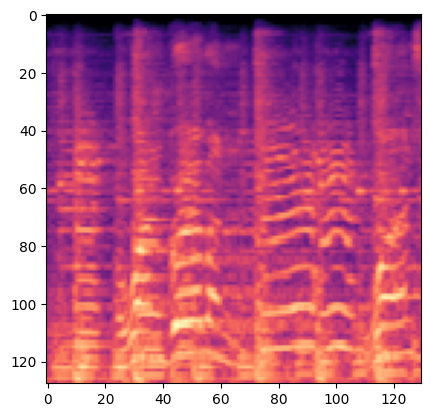

In [ ]:
bl1.files

plt.imshow(bl1['pic'])
bl1['audio_features']
bl1['label']
bl1['pic'].shape

# Data Retrieval form Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Google Drive path to NAML_PROJECT shared folder
DRIVE_PATH = '/content/drive/MyDrive/NAML_PROJECT/'
NPZ_DRIVE_PATH = '/content/drive/MyDrive/NAML_PROJECT/NPZ.zip'
CSV_DRIVE_PATH = '/content/drive/MyDrive/NAML_PROJECT/features_npz.csv'
MODELS_LOG_PATH = '/content/drive/MyDrive/NAML_PROJECT/models_log/'

In [ ]:
!unzip $NPZ_DRIVE_PATH -d ./

Output streaming troncato alle ultime 5000 righe.
  inflating: ./NPZ/disco/disco.00074.9.npz  
  inflating: ./NPZ/disco/disco.00061.8.npz  
  inflating: ./NPZ/disco/disco.00075.4.npz  
  inflating: ./NPZ/disco/disco.00048.1.npz  
  inflating: ./NPZ/disco/disco.00087.4.npz  
  inflating: ./NPZ/disco/disco.00019.1.npz  
  inflating: ./NPZ/disco/disco.00017.2.npz  
   creating: ./NPZ/classical/
  inflating: ./NPZ/classical/classical.00004.9.npz  
  inflating: ./NPZ/classical/classical.00028.7.npz  
  inflating: ./NPZ/classical/classical.00055.0.npz  
  inflating: ./NPZ/classical/classical.00085.4.npz  
  inflating: ./NPZ/classical/classical.00077.0.npz  
  inflating: ./NPZ/classical/classical.00015.3.npz  
  inflating: ./NPZ/classical/classical.00031.7.npz  
  inflating: ./NPZ/classical/classical.00039.0.npz  
  inflating: ./NPZ/classical/classical.00060.5.npz  
  inflating: ./NPZ/classical/classical.00022.6.npz  
  inflating: ./NPZ/classical/classical.00026.7.npz  
  inflating: ./NPZ/cla

In [ ]:
data = pd.read_csv(CSV_DRIVE_PATH)
data['npz_path'] = 'NPZ/' + data['filename'].apply(lambda x: x.split('.')[0]) + '/' + data['filename'] + '.npz'
data.head()

,filename,npz_path,label
0,blues.00000.0,NPZ/blues/blues.00000.0.npz,blues
1,blues.00000.1,NPZ/blues/blues.00000.1.npz,blues
2,blues.00000.2,NPZ/blues/blues.00000.2.npz,blues
3,blues.00000.3,NPZ/blues/blues.00000.3.npz,blues
4,blues.00000.4,NPZ/blues/blues.00000.4.npz,blues


# Data preparation for T/V/T



In [ ]:
def train_val_test_split(X, train_size, val_size, test_size):
    X_train, X_val_test = train_test_split(X, train_size=train_size, stratify=X['label'])
    X_val, X_test = train_test_split(X_val_test, test_size=test_size/(test_size + val_size), stratify=X_val_test['label'])
    return X_train, X_val, X_test

In [ ]:
labels = list(data['label'].unique())

# Encode set labels to one hot vectors
def one_hot_encode(label):
    encoded = [0] * len(labels)
    encoded[labels.index(label)] = 1
    return encoded

# Decode one hot vectors to set labels
def one_hot_decode(encoded):
    return labels[encoded.index(1)]

def one_hot_decode_np(encoded):
    return labels[np.argmax(encoded)]

In [ ]:
def get_X_y(df):
    X_pic, X_audio_features, y = [], [], []

    for name in df['npz_path']:
        loaded_npz = np.load(name, allow_pickle=True)

        pic = loaded_npz['pic']
        X_pic.append(np.asarray(pic, dtype=np.float32))

        audio_features = loaded_npz['audio_features']
        X_audio_features.append(np.asarray(audio_features, dtype=np.float32))

        label = one_hot_encode(loaded_npz['label'])
        y.append(np.asarray(label, dtype=np.float32))
    
    return np.array(X_pic), np.array(X_audio_features), np.array(y)         

# Models creation

In [ ]:
def dense_block(input_layer, output_dim):
  dense = keras.layers.Dense(output_dim, activation = 'relu')(input_layer)
  batch_norm = keras.layers.BatchNormalization()(dense)
  dropout = keras.layers.Dropout(rate = 0.4)(batch_norm)

  return dropout

In [ ]:
def convolution_block(input_layer, filters = 64, pooling_operation = 'max', pool_size = 2, strides = 2):
  conv = keras.layers.Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(input_layer)
  batch_norm = keras.layers.BatchNormalization()(conv)
  if pooling_operation == 'max':
    pool = keras.layers.MaxPool2D(pool_size = pool_size, strides = strides)(batch_norm)
  elif pooling_operation == 'avg':
    pool = keras.layers.AvgPool2D(pool_size = pool_size, strides = strides)(batch_norm)
  dropout = keras.layers.Dropout(rate = 0.1)(pool)

  return dropout

In [ ]:
def rnn_block(input_layer):
  gru_1 = keras.layers.GRU(32, return_sequences = True, return_state = True)(input_layer)
  gru_2 = keras.layers.GRU(32)(gru_1)

  return gru_2

In [ ]:
def create_model(mode = 'benchmark', sub_mode = ''):
  # VFE module
  input_vfe = keras.layers.Input(shape = [128, 130, 3])

  ## First Convolutional block
  output_conv_max_1 = convolution_block(input_vfe)

  ## Second Convolutional block
  output_conv_max_2 = convolution_block(output_conv_max_1, filters = 128, pool_size = 3, strides = 3)

  ## Third Convolutional block
  output_conv_max_3 = convolution_block(output_conv_max_2, filters = 128, pool_size = 4, strides = 4)

  ## Fourth Convolutional block - Parallel of Max and Average Pooling
  ### Average Pooling block
  output_conv_avg_4 = convolution_block(output_conv_max_3, filters = 128, pooling_operation = 'avg', pool_size = 4, strides = 4)

  ### Flattening the Average Pooling block
  flatten_avg_vfe = keras.layers.Flatten()(output_conv_avg_4)

  ### Max Pooling block
  output_conv_max_4 = convolution_block(output_conv_max_3, filters = 128, pool_size = 4, strides = 4)

  ### Reshape layer for correct input shape to the RNN
  shape = (8,16)
  if mode == 'vision' and sub_mode == 'a':
    shape = (16,8)
  input_rnn = reshape_max_vfe = keras.layers.Reshape(shape)(output_conv_max_4)

  ## RNN part of the VFE module (2-layer GRU)
  if mode != 'vision':
    output_rnn = rnn_block(input_rnn)

  # ==============================================================================

  # AFE module
  input_afe = keras.layers.Input(shape = [55,])

  ## First Dense block (Dense, Batch Normalization, Dropout)
  output_dense_1 = dense_block(input_afe, 1024)

  ## Input to second block
  input_dense_2 = output_dense_1
  if mode == 'audio':
    if sub_mode == 'A1':
      input_dense_2 = keras.layers.Concatenate()([output_rnn, output_dense_1])
    elif sub_mode == 'B1':
      input_dense_2 = keras.layers.Concatenate()([flatten_avg_vfe, output_dense_1])
  elif mode == 'vision':
    if sub_mode == 'e':
      reshape = keras.layers.Reshape((64,16))(output_dense_1)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
  elif mode == 'two_way':
    if sub_mode == 'A1_e':
      reshape = keras.layers.Reshape((64,16))(output_dense_1)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
      input_dense_2 = keras.layers.Concatenate()([output_rnn, output_dense_1])
    elif sub_mode == 'B1_e':
      reshape = keras.layers.Reshape((64,16))(output_dense_1)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
      input_dense_2 = keras.layers.Concatenate()([flatten_avg_vfe, output_dense_1])
  
  ## Second Dense block (Dense, Batch Normalization, Dropout)
  output_dense_2 = dense_block(input_dense_2, 512)

  ## Input to third block
  input_dense_3 = output_dense_2
  if mode == 'audio':
    if sub_mode == 'A2':
      input_dense_3 = keras.layers.Concatenate()([output_rnn, output_dense_2])
    elif sub_mode == 'B2':
      input_dense_3 = keras.layers.Concatenate()([flatten_avg_vfe, output_dense_2])
  elif mode == 'vision':
    if sub_mode == 'd':
      reshape = keras.layers.Reshape((32,16))(output_dense_2)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
  elif mode == 'two_way':
    if sub_mode == 'A2_d':
      reshape = keras.layers.Reshape((32,16))(output_dense_2)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
      input_dense_3 = keras.layers.Concatenate()([output_rnn, output_dense_2])
    elif sub_mode == 'B2_d':
      reshape = keras.layers.Reshape((32,16))(output_dense_2)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
      input_dense_3 = keras.layers.Concatenate()([flatten_avg_vfe, output_dense_2])
  
  ## Third dense block (Dense, Batch Normalization, Dropout)
  output_dense_3 = dense_block(input_dense_3, 256)

  ## Input to fourth block
  input_dense_4 = output_dense_3
  if mode == 'audio':
    if sub_mode == 'A3':
      input_dense_4 = keras.layers.Concatenate()([output_rnn, output_dense_3])
    elif sub_mode == 'B3':
      input_dense_4 = keras.layers.Concatenate()([flatten_avg_vfe, output_dense_3])
  elif mode == 'vision':
    if sub_mode == 'c':
      reshape = keras.layers.Reshape((16,16))(output_dense_3)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
  elif mode == 'two_way':
    if sub_mode == 'A3_c':
      reshape = keras.layers.Reshape((16,16))(output_dense_3)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
      input_dense_4 = keras.layers.Concatenate()([output_rnn, output_dense_3])
    elif sub_mode == 'B3_c':
      reshape = keras.layers.Reshape((16,16))(output_dense_3)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
      input_dense_4 = keras.layers.Concatenate()([flatten_avg_vfe, output_dense_3])
  
  ## Fourth dense block (Dense, Batch Normalization, Dropout)
  output_dense_4 = dense_block(input_dense_4, 128)

  ## Input to fifth block
  input_dense_5 = output_dense_4
  if mode == 'audio':
    if sub_mode == 'A4':
      input_dense_5 = keras.layers.Concatenate()([output_rnn, output_dense_4])
    elif sub_mode == 'B4':
      input_dense_5 = keras.layers.Concatenate()([flatten_avg_vfe, output_dense_4])
  elif mode == 'vision':
    if sub_mode == 'b':
      reshape = keras.layers.Reshape((8,16))(output_dense_4)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
  elif mode == 'two_way':
    if sub_mode == 'A4_b':
      reshape = keras.layers.Reshape((8,16))(output_dense_4)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
      input_dense_5 = keras.layers.Concatenate()([output_rnn, output_dense_4])
    elif sub_mode == 'B4_b':
      reshape = keras.layers.Reshape((8,16))(output_dense_4)
      input_rnn = keras.layers.Concatenate(axis = -2)([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)
      input_dense_5 = keras.layers.Concatenate()([flatten_avg_vfe, output_dense_4])
  
  ## Fifth dense block (Dense, Batch Normalization, Dropout)
  output_afe = output_dense_5 = dense_block(input_dense_5, 64)

  if mode == 'vision':
    if sub_mode == 'a':
      reshape = keras.layers.Reshape((16,4))(output_dense_5)
      input_rnn = keras.layers.Concatenate()([reshape_max_vfe, reshape])
      output_rnn = rnn_block(input_rnn)

  # ==============================================================================

  # Concatenate outputs
  concatenate = keras.layers.Concatenate()([flatten_avg_vfe, output_rnn, output_afe])

  # Output layer
  output = keras.layers.Dense(10, activation = 'softmax')(concatenate)

  # ==============================================================================

  model = keras.models.Model(inputs = [input_afe, input_vfe], outputs = [output])
  if sub_mode == '':
    model_name = mode + '_model.png'
  else:
    model_name = mode + '_' + sub_mode + '_model.png'
  plot_model(model, model_name, show_shapes = True)
  
  return model

# Model Training and Testing

In [ ]:
# All possible models (mode, sub_mode)
models = {
    'audio_A1': ('audio', 'A1'),
    'audio_A2': ('audio', 'A2'),
    'audio_A3': ('audio', 'A3'),
    'audio_A4': ('audio', 'A4'),
    'audio_B1': ('audio', 'B1'),
    'audio_B2': ('audio', 'B2'),
    'audio_B3': ('audio', 'B3'),
    'audio_B4': ('audio', 'B4'),
    'vision_a': ('vision', 'a'),
    'vision_b': ('vision', 'b'),
    'vision_c': ('vision', 'c'),
    'vision_d': ('vision', 'd'),
    'vision_e': ('vision', 'e'),
    'two_way_A1_e': ('two_way', 'A1_e'),
    'two_way_A2_d': ('two_way', 'A2_d'),
    'two_way_A3_c': ('two_way', 'A3_c'),
    'two_way_A4_b': ('two_way', 'A4_b'),
    'two_way_B1_e': ('two_way', 'B1_e'),
    'two_way_B2_d': ('two_way', 'B2_d'),
    'two_way_B3_c': ('two_way', 'B3_c'),
    'two_way_B4_b': ('two_way', 'B4_b')
}

In [ ]:
# Cross validation training loop
def k_fold_training(model = ('benchmark', '')):
  mode = model[0]
  sub_mode = model[1]

  k_fold = 10
  num_classes = 10

  train_size = 0.7
  val_size = 0.2
  test_size = 0.1

  epochs = 100
  batch_size = 128
  learning_rate = 0.01
  file_name0 = 'model.hdf5'
  path  = './models_log/' + mode + '/'

  if sub_mode != '':
    path = path + sub_mode + '/'

  csv_name0 = 'log.csv'
  train_loss_record = []
  train_acc_record = []
  val_loss_record = []
  val_acc_record = []
  test_loss_record = []
  test_acc_record = []
  confusion_matrix_record = []

  for i in range(k_fold):

      print(f'Start {i+1} fold training')

      # Data splitting and data retrieval
      X_train, X_val, X_test = train_val_test_split(data, train_size=train_size, val_size=val_size, test_size=test_size)
      X_train_pic, X_train_audio_features, y_train = get_X_y(X_train)
      X_val_pic, X_val_audio_features, y_val = get_X_y(X_val)
      X_test_pic, X_test_audio_features, y_test = get_X_y(X_test)

      # Data normalization
      scaler = StandardScaler()
      X_train_audio_features = scaler.fit_transform(X_train_audio_features)
      X_val_audio_features = scaler.transform(X_val_audio_features)
      X_test_audio_features = scaler.transform(X_test_audio_features)

      X_train_pic = X_train_pic / 255.0
      X_val_pic = X_val_pic / 255.0
      X_test_pic = X_test_pic / 255.0

      # Logs paths
      file_name = path + str(i+1) + '_fold_' + file_name0
      csv_path  = path + str(i+1) + '_fold_' + csv_name0

      # Model creation
      lr_change = keras.callbacks.ReduceLROnPlateau()
      model_checkpoint = keras.callbacks.ModelCheckpoint(file_name, monitor='val_accuracy', save_best_only=True, mode='max')
      early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=10, start_from_epoch=40, mode='max', verbose=1)
      csv_logger = keras.callbacks.CSVLogger(csv_path)

      callbacks =[lr_change, model_checkpoint, early_stopping,csv_logger]
      opt = keras.optimizers.Adam(learning_rate=learning_rate)
      model = create_model(mode=mode, sub_mode=sub_mode)

      model.compile(
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=opt)
      
      # Training
      model.fit(
          x = [X_train_audio_features, X_train_pic],
          y = y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=([X_val_audio_features, X_val_pic], y_val), 
          verbose=1,
          callbacks=callbacks)
      
      # Testing the best model obtained during the i-th fold training
      model_best = keras.models.load_model(file_name)
      train_loss, train_acc = model_best.evaluate([X_train_audio_features, X_train_pic], y_train, batch_size=batch_size, verbose=0)
      val_loss, val_acc = model_best.evaluate([X_val_audio_features, X_val_pic], y_val, batch_size=batch_size, verbose=0)
      test_loss, test_acc = model_best.evaluate([X_test_audio_features, X_test_pic], y_test, batch_size=batch_size, verbose=0)
      y_pred = model_best.predict([X_test_audio_features, X_test_pic])
      
      train_loss_record.append(train_loss)
      train_acc_record.append(train_acc)
      val_loss_record.append(val_loss)
      val_acc_record.append(val_acc)
      test_loss_record.append(test_loss)
      test_acc_record.append(test_acc)

      y_test = [one_hot_decode_np(label) for label in y_test]
      y_pred = [one_hot_decode_np(label) for label in y_pred]

      confusion_matrix_record.append(confusion_matrix(y_test, y_pred))

      print(f'\n\n {i+1} fold train loss {train_loss:.4f} train acc {train_acc:.4f}, val loss {val_loss:.4f} \
                          val acc {val_acc:.4f}, test loss {test_loss:.4f} test acc {test_acc:.4f}\n\n')
      
      print(f'{gc.collect()} objects collected from the garbage collector\n\n')

  train_loss_avg = np.mean(np.array(train_loss_record))
  train_acc_avg = np.mean(np.array(train_acc_record))
  val_loss_avg = np.mean(np.array(val_loss_record))
  val_acc_avg = np.mean(np.array(val_acc_record))
  test_loss_avg = np.mean(np.array(test_loss_record))
  test_acc_avg = np.mean(np.array(test_acc_record))

  print(f'\n\n{k_fold} fold train loss avg {train_loss_avg :.4f} train acc avg {train_acc_avg:.4f}, val loss avg {val_loss_avg:.4f} \
                        val acc avg {val_acc_avg:.4f}, test loss avg {test_loss_avg:.4f} test acc avg {test_acc_avg:.4f}')
  

  # Write results on the csv
  row = [mode + '_' + sub_mode, mode, sub_mode, test_acc_avg]
  result = pd.read_csv(DRIVE_PATH + '/results.csv')
  result.loc[len(result)] = row
  result.to_csv(DRIVE_PATH + '/results.csv', index=False)

  return test_acc_avg, confusion_matrix_record

## Benchmark Model

In [ ]:
# Training benchmark model - DONE
# benchmark_avg_acc = k_fold_training()

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 43s 323ms/step - loss: 1.3405 - accuracy: 0.5283 - val_loss: 7.2042 - val_accuracy: 0.3262 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 14s 264ms/step - loss: 0.8851 - accuracy: 0.6947 - val_loss: 5.7190 - val_accuracy: 0.3858 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 14s 264ms/step - loss: 0.7232 - accuracy: 0.7554 - val_loss: 3.5011 - val_accuracy: 0.4359 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 265ms/step - loss: 0.6344 - accuracy: 0.7867 - val_loss: 1.6262 - val_accuracy: 0.5636 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 14s 251ms/step - loss: 0.5651 - accuracy: 0.8119 - val_loss: 2.3716 - val_accuracy: 0.5276 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 14s 252ms/step - loss: 0.5164 - accuracy: 0.8287 - val_loss: 4.3428 - val_accuracy: 0.4289 - lr: 0.0100
Epoch 7/100
55/55 [=================

## Audio Models

### Audio A1 Model

In [ ]:
# Training audio A1 model - DONE
# audio_A1_avg_acc = k_fold_training(models['audio_A1'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 45s 348ms/step - loss: 1.3802 - accuracy: 0.5190 - val_loss: 6.8870 - val_accuracy: 0.2931 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 15s 267ms/step - loss: 0.8993 - accuracy: 0.6894 - val_loss: 4.9180 - val_accuracy: 0.3477 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 15s 265ms/step - loss: 0.7163 - accuracy: 0.7572 - val_loss: 5.4748 - val_accuracy: 0.3958 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 14s 264ms/step - loss: 0.6247 - accuracy: 0.7851 - val_loss: 6.9829 - val_accuracy: 0.3231 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 14s 264ms/step - loss: 0.5470 - accuracy: 0.8143 - val_loss: 6.0052 - val_accuracy: 0.3372 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 266ms/step - loss: 0.5140 - accuracy: 0.8252 - val_loss: 2.3893 - val_accuracy: 0.5210 - lr: 0.0100
Epoch 7/100
55/55 [=================

### Audio A2 Model

In [ ]:
# Training audio A2 model - DONE
# audio_A2_avg_acc = k_fold_training(models['audio_A2'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 44s 361ms/step - loss: 1.3670 - accuracy: 0.5186 - val_loss: 3.2365 - val_accuracy: 0.3933 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 15s 267ms/step - loss: 0.8752 - accuracy: 0.6905 - val_loss: 2.8554 - val_accuracy: 0.4233 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 14s 262ms/step - loss: 0.7411 - accuracy: 0.7419 - val_loss: 5.5962 - val_accuracy: 0.3768 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 267ms/step - loss: 0.6432 - accuracy: 0.7804 - val_loss: 1.9675 - val_accuracy: 0.5441 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 267ms/step - loss: 0.5833 - accuracy: 0.8075 - val_loss: 1.5169 - val_accuracy: 0.6062 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 14s 258ms/step - loss: 0.4818 - accuracy: 0.8322 - val_loss: 1.2454 - val_accuracy: 0.6779 - lr: 0.0100
Epoch 7/100
55/55 [=================

### Audio A3 Model

In [ ]:
# Training audio A3 model - DONE
# audio_A3_avg_acc = k_fold_training(models['audio_A3'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 42s 360ms/step - loss: 1.3892 - accuracy: 0.5149 - val_loss: 6.0967 - val_accuracy: 0.2836 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 15s 271ms/step - loss: 0.9025 - accuracy: 0.6845 - val_loss: 3.5303 - val_accuracy: 0.4349 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 14s 260ms/step - loss: 0.7328 - accuracy: 0.7504 - val_loss: 2.5953 - val_accuracy: 0.4629 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 14s 258ms/step - loss: 0.6322 - accuracy: 0.7847 - val_loss: 3.8219 - val_accuracy: 0.4609 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 14s 261ms/step - loss: 0.5751 - accuracy: 0.8069 - val_loss: 3.0010 - val_accuracy: 0.5245 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 270ms/step - loss: 0.4684 - accuracy: 0.8410 - val_loss: 3.0875 - val_accuracy: 0.4349 - lr: 0.0100
Epoch 7/100
55/55 [=================

ValueError: ignored

### Audio A4 Model

In [ ]:
# Training audio A4 model - DONE
# audio_A4_avg_acc = k_fold_training(models['audio_A4'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 44s 351ms/step - loss: 1.3137 - accuracy: 0.5468 - val_loss: 3.8990 - val_accuracy: 0.3622 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 14s 262ms/step - loss: 0.8771 - accuracy: 0.6958 - val_loss: 3.3100 - val_accuracy: 0.4354 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 14s 257ms/step - loss: 0.7033 - accuracy: 0.7608 - val_loss: 6.3391 - val_accuracy: 0.3677 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 14s 261ms/step - loss: 0.6149 - accuracy: 0.7830 - val_loss: 4.4582 - val_accuracy: 0.4474 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 269ms/step - loss: 0.5520 - accuracy: 0.8139 - val_loss: 3.3930 - val_accuracy: 0.3928 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 267ms/step - loss: 0.4837 - accuracy: 0.8340 - val_loss: 2.0173 - val_accuracy: 0.5451 - lr: 0.0100
Epoch 7/100
55/55 [=================

### Audio B1 Model

In [ ]:
# Training audio B1 model - DONE
# audio_B1_avg_acc = k_fold_training(models['audio_B1'])

### Audio B2 Model

In [ ]:
# Training audio B2 model - DONE
# audio_B2_avg_acc = k_fold_training(models['audio_B2'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 44s 336ms/step - loss: 1.3158 - accuracy: 0.5402 - val_loss: 6.9308 - val_accuracy: 0.3081 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 15s 272ms/step - loss: 0.8539 - accuracy: 0.7067 - val_loss: 2.7181 - val_accuracy: 0.4895 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 15s 267ms/step - loss: 0.6894 - accuracy: 0.7680 - val_loss: 3.1303 - val_accuracy: 0.3973 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 268ms/step - loss: 0.6061 - accuracy: 0.7962 - val_loss: 7.4672 - val_accuracy: 0.2320 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 267ms/step - loss: 0.5335 - accuracy: 0.8176 - val_loss: 5.6735 - val_accuracy: 0.2751 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 268ms/step - loss: 0.4494 - accuracy: 0.8530 - val_loss: 15.7345 - val_accuracy: 0.1162 - lr: 0.0100
Epoch 7/100
55/55 [================

### Audio B3 Model

In [ ]:
# Training audio B3 model - DONE
# audio_B3_avg_acc = k_fold_training(models['audio_B3'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 42s 324ms/step - loss: 1.3754 - accuracy: 0.5163 - val_loss: 7.2480 - val_accuracy: 0.3111 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 14s 264ms/step - loss: 0.8430 - accuracy: 0.7035 - val_loss: 8.7682 - val_accuracy: 0.2660 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 14s 259ms/step - loss: 0.7090 - accuracy: 0.7538 - val_loss: 5.9289 - val_accuracy: 0.4048 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 267ms/step - loss: 0.6226 - accuracy: 0.7907 - val_loss: 4.3245 - val_accuracy: 0.4188 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 14s 260ms/step - loss: 0.5363 - accuracy: 0.8211 - val_loss: 1.8731 - val_accuracy: 0.5576 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 14s 256ms/step - loss: 0.4963 - accuracy: 0.8335 - val_loss: 1.7221 - val_accuracy: 0.5446 - lr: 0.0100
Epoch 7/100
55/55 [=================

### Audio B4 Model

In [ ]:
# Training audio B4 model - DONE
# audio_B4_avg_acc = k_fold_training(models['audio_B4'])

## Vision Models

### Vision a Model

In [ ]:
# Training vision a model - DONE
# vision_a_avg_acc = k_fold_training(models['vision_a'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 40s 322ms/step - loss: 1.3389 - accuracy: 0.5385 - val_loss: 5.1837 - val_accuracy: 0.3943 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 14s 261ms/step - loss: 0.8398 - accuracy: 0.7098 - val_loss: 7.3777 - val_accuracy: 0.3853 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 14s 254ms/step - loss: 0.7130 - accuracy: 0.7572 - val_loss: 6.9640 - val_accuracy: 0.3277 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 14s 257ms/step - loss: 0.6351 - accuracy: 0.7860 - val_loss: 3.9888 - val_accuracy: 0.4489 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 14s 253ms/step - loss: 0.5562 - accuracy: 0.8113 - val_loss: 3.3103 - val_accuracy: 0.4238 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 14s 257ms/step - loss: 0.4960 - accuracy: 0.8264 - val_loss: 3.0065 - val_accuracy: 0.5486 - lr: 0.0100
Epoch 7/100
55/55 [=================

### Vision b Model

In [ ]:
# Training vision b model - DONE
# vision_b_avg_acc = k_fold_training(models['vision_b'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 42s 360ms/step - loss: 1.3413 - accuracy: 0.5358 - val_loss: 5.4979 - val_accuracy: 0.3186 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 14s 255ms/step - loss: 0.8570 - accuracy: 0.7034 - val_loss: 8.0089 - val_accuracy: 0.2565 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 15s 264ms/step - loss: 0.7297 - accuracy: 0.7532 - val_loss: 6.8378 - val_accuracy: 0.3377 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 269ms/step - loss: 0.6207 - accuracy: 0.7877 - val_loss: 2.3428 - val_accuracy: 0.4544 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 271ms/step - loss: 0.5498 - accuracy: 0.8171 - val_loss: 1.4427 - val_accuracy: 0.6157 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 14s 260ms/step - loss: 0.4961 - accuracy: 0.8338 - val_loss: 0.8985 - val_accuracy: 0.7340 - lr: 0.0100
Epoch 7/100
55/55 [=================

### Vision c Model

In [ ]:
# Training vision c model - DONE
# vision_c_avg_acc = k_fold_training(models['vision_c'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 42s 331ms/step - loss: 1.3077 - accuracy: 0.5451 - val_loss: 4.2209 - val_accuracy: 0.3612 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 15s 274ms/step - loss: 0.8323 - accuracy: 0.7130 - val_loss: 3.2147 - val_accuracy: 0.4449 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 15s 275ms/step - loss: 0.6733 - accuracy: 0.7700 - val_loss: 2.7843 - val_accuracy: 0.5060 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 273ms/step - loss: 0.5772 - accuracy: 0.7980 - val_loss: 2.6930 - val_accuracy: 0.4474 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 277ms/step - loss: 0.4997 - accuracy: 0.8289 - val_loss: 2.1068 - val_accuracy: 0.5291 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 265ms/step - loss: 0.4565 - accuracy: 0.8434 - val_loss: 1.2525 - val_accuracy: 0.6668 - lr: 0.0100
Epoch 7/100
55/55 [=================

### Vision d Model

In [ ]:
# Training vision d model - DONE
# vision_d_avg_acc = k_fold_training(models['vision_d'])

### Vision e Model

In [ ]:
# Training vision e model - DONE
# vision_e_avg_acc = k_fold_training(models['vision_e'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 43s 358ms/step - loss: 1.2691 - accuracy: 0.5607 - val_loss: 6.0928 - val_accuracy: 0.3537 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 15s 275ms/step - loss: 0.8048 - accuracy: 0.7141 - val_loss: 3.1534 - val_accuracy: 0.4474 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 15s 265ms/step - loss: 0.6445 - accuracy: 0.7839 - val_loss: 10.3363 - val_accuracy: 0.3016 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 266ms/step - loss: 0.5471 - accuracy: 0.8132 - val_loss: 2.7884 - val_accuracy: 0.5301 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 274ms/step - loss: 0.4970 - accuracy: 0.8302 - val_loss: 2.6606 - val_accuracy: 0.5105 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 272ms/step - loss: 0.4256 - accuracy: 0.8534 - val_loss: 1.0761 - val_accuracy: 0.7039 - lr: 0.0100
Epoch 7/100
55/55 [================

## Two-way Models

### Two-way A1_e Model

In [ ]:
# Training two-way A1_e model - DONE
# two_way_A1_e_avg_acc = k_fold_training(models['two_way_A1_e'])

### Two-way A2_d Model

In [ ]:
# Training two-way A2_d model - DONE
# two_way_A2_d_avg_acc = k_fold_training(models['two_way_A2_d'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 44s 357ms/step - loss: 1.2457 - accuracy: 0.5653 - val_loss: 13.6192 - val_accuracy: 0.2315 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 15s 273ms/step - loss: 0.8029 - accuracy: 0.7243 - val_loss: 2.0632 - val_accuracy: 0.4744 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 15s 269ms/step - loss: 0.6564 - accuracy: 0.7687 - val_loss: 4.9078 - val_accuracy: 0.3878 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 269ms/step - loss: 0.5899 - accuracy: 0.7967 - val_loss: 5.2957 - val_accuracy: 0.3587 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 270ms/step - loss: 0.4905 - accuracy: 0.8325 - val_loss: 6.2817 - val_accuracy: 0.3617 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 273ms/step - loss: 0.4250 - accuracy: 0.8560 - val_loss: 2.6450 - val_accuracy: 0.5266 - lr: 0.0100
Epoch 7/100
55/55 [================

### Two-way A3_c Model

In [ ]:
# Training two-way A3_c model - DONE
# two_way_A3_c_avg_acc = k_fold_training(models['two_way_A3_c'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 42s 332ms/step - loss: 1.3177 - accuracy: 0.5404 - val_loss: 5.7298 - val_accuracy: 0.3522 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 15s 270ms/step - loss: 0.8528 - accuracy: 0.7033 - val_loss: 4.1560 - val_accuracy: 0.3747 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 14s 259ms/step - loss: 0.6941 - accuracy: 0.7589 - val_loss: 2.0898 - val_accuracy: 0.5015 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 267ms/step - loss: 0.5845 - accuracy: 0.8006 - val_loss: 3.4050 - val_accuracy: 0.4379 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 271ms/step - loss: 0.5145 - accuracy: 0.8274 - val_loss: 1.2808 - val_accuracy: 0.6388 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 269ms/step - loss: 0.4590 - accuracy: 0.8423 - val_loss: 1.4899 - val_accuracy: 0.6032 - lr: 0.0100
Epoch 7/100
55/55 [=================

### Two-way A4_b Model

In [ ]:
# Training two-way A4_b model - DONE
# two_way_A4_b_avg_acc = k_fold_training(models['two_way_A4_b'])

### Two-way B1_e Model

In [ ]:
# Training two-way B1_e model - DONE
# two_way_B1_e_avg_acc = k_fold_training(models['two_way_B1_e'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 43s 353ms/step - loss: 1.2764 - accuracy: 0.5676 - val_loss: 7.3706 - val_accuracy: 0.2300 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 14s 261ms/step - loss: 0.7945 - accuracy: 0.7289 - val_loss: 1.3295 - val_accuracy: 0.6147 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 15s 267ms/step - loss: 0.6746 - accuracy: 0.7708 - val_loss: 4.4701 - val_accuracy: 0.4404 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 14s 259ms/step - loss: 0.5711 - accuracy: 0.8085 - val_loss: 5.7152 - val_accuracy: 0.3732 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 14s 259ms/step - loss: 0.4833 - accuracy: 0.8378 - val_loss: 2.5007 - val_accuracy: 0.5115 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 269ms/step - loss: 0.4481 - accuracy: 0.8480 - val_loss: 1.6860 - val_accuracy: 0.6002 - lr: 0.0100
Epoch 7/100
55/55 [=================

### Two-way B2_d Model

In [ ]:
# Training two-way B2_d model - DONE
# two_way_B2_d_avg_acc = k_fold_training(models['two_way_B2_d'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 43s 350ms/step - loss: 1.3217 - accuracy: 0.5372 - val_loss: 15.7398 - val_accuracy: 0.1268 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 14s 259ms/step - loss: 0.8341 - accuracy: 0.7120 - val_loss: 5.1164 - val_accuracy: 0.3126 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 15s 265ms/step - loss: 0.6966 - accuracy: 0.7650 - val_loss: 7.3206 - val_accuracy: 0.2255 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 14s 257ms/step - loss: 0.6008 - accuracy: 0.7963 - val_loss: 2.1078 - val_accuracy: 0.5185 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 264ms/step - loss: 0.5129 - accuracy: 0.8289 - val_loss: 3.2159 - val_accuracy: 0.4153 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 268ms/step - loss: 0.4353 - accuracy: 0.8511 - val_loss: 1.3449 - val_accuracy: 0.6333 - lr: 0.0100
Epoch 7/100
55/55 [================

### Two-way B3_c Model

In [ ]:
# Training two-way B3_c model - DONE
# two_way_B3_c_avg_acc = k_fold_training(models['two_way_B3_c'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 43s 323ms/step - loss: 1.3428 - accuracy: 0.5372 - val_loss: 8.1425 - val_accuracy: 0.2595 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 14s 257ms/step - loss: 0.8536 - accuracy: 0.7034 - val_loss: 3.2324 - val_accuracy: 0.4374 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 14s 264ms/step - loss: 0.7170 - accuracy: 0.7611 - val_loss: 6.2168 - val_accuracy: 0.2951 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 14s 254ms/step - loss: 0.5911 - accuracy: 0.7987 - val_loss: 3.7076 - val_accuracy: 0.3853 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 267ms/step - loss: 0.5388 - accuracy: 0.8185 - val_loss: 2.9293 - val_accuracy: 0.4614 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 266ms/step - loss: 0.4943 - accuracy: 0.8327 - val_loss: 2.1551 - val_accuracy: 0.5165 - lr: 0.0100
Epoch 7/100
55/55 [=================

### Two-way B4_b Model

In [ ]:
# Training two-way B4_b model - DONE
# two_way_B4_b_avg_acc = k_fold_training(models['two_way_B4_b'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 42s 355ms/step - loss: 1.2964 - accuracy: 0.5376 - val_loss: 12.7207 - val_accuracy: 0.2680 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 14s 261ms/step - loss: 0.8611 - accuracy: 0.7030 - val_loss: 1.7633 - val_accuracy: 0.5551 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 14s 255ms/step - loss: 0.7127 - accuracy: 0.7588 - val_loss: 6.6289 - val_accuracy: 0.3462 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 267ms/step - loss: 0.6171 - accuracy: 0.7947 - val_loss: 5.5268 - val_accuracy: 0.4218 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 14s 259ms/step - loss: 0.5744 - accuracy: 0.8036 - val_loss: 3.8355 - val_accuracy: 0.4394 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 15s 267ms/step - loss: 0.5105 - accuracy: 0.8275 - val_loss: 5.2632 - val_accuracy: 0.3006 - lr: 0.0100
Epoch 7/100
55/55 [================

## Save the logs to the Drive folder

In [ ]:
# Save all the models in Google Drive
!cp -r ./models_log $DRIVE_PATH

## Retrain best model for data visualization purposes

In [ ]:
# Training two-way B2_d model - DONE
two_way_B2_d_avg_acc, two_way_B2_d_cm_record = k_fold_training(models['two_way_B2_d'])

Start 1 fold training
Epoch 1/100
55/55 [==============================] - 46s 353ms/step - loss: 1.3557 - accuracy: 0.5261 - val_loss: 9.0193 - val_accuracy: 0.3086 - lr: 0.0100
Epoch 2/100
55/55 [==============================] - 15s 274ms/step - loss: 0.8489 - accuracy: 0.7107 - val_loss: 2.1294 - val_accuracy: 0.5115 - lr: 0.0100
Epoch 3/100
55/55 [==============================] - 15s 268ms/step - loss: 0.7116 - accuracy: 0.7534 - val_loss: 1.7043 - val_accuracy: 0.5661 - lr: 0.0100
Epoch 4/100
55/55 [==============================] - 15s 275ms/step - loss: 0.5892 - accuracy: 0.7962 - val_loss: 8.1963 - val_accuracy: 0.3412 - lr: 0.0100
Epoch 5/100
55/55 [==============================] - 15s 266ms/step - loss: 0.5232 - accuracy: 0.8194 - val_loss: 1.6987 - val_accuracy: 0.6232 - lr: 0.0100
Epoch 6/100
55/55 [==============================] - 14s 263ms/step - loss: 0.4480 - accuracy: 0.8491 - val_loss: 1.1972 - val_accuracy: 0.6789 - lr: 0.0100
Epoch 7/100
55/55 [=================

In [ ]:
two_way_B2_d_cm_record[2]

array([[99,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0, 99,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  2, 93,  0,  0,  1,  0,  0,  0,  3],
       [ 0,  0,  0, 93,  0,  0,  0,  0,  2,  5],
       [ 1,  0,  0,  2, 94,  0,  1,  2,  0,  0],
       [ 0,  4,  1,  0,  0, 93,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 97,  0,  0,  3],
       [ 0,  0,  2,  0,  0,  0,  0, 96,  0,  2],
       [ 0,  1,  0,  1,  3,  0,  0,  1, 94,  0],
       [ 0,  0,  0,  1,  0,  1,  1,  0,  1, 96]])

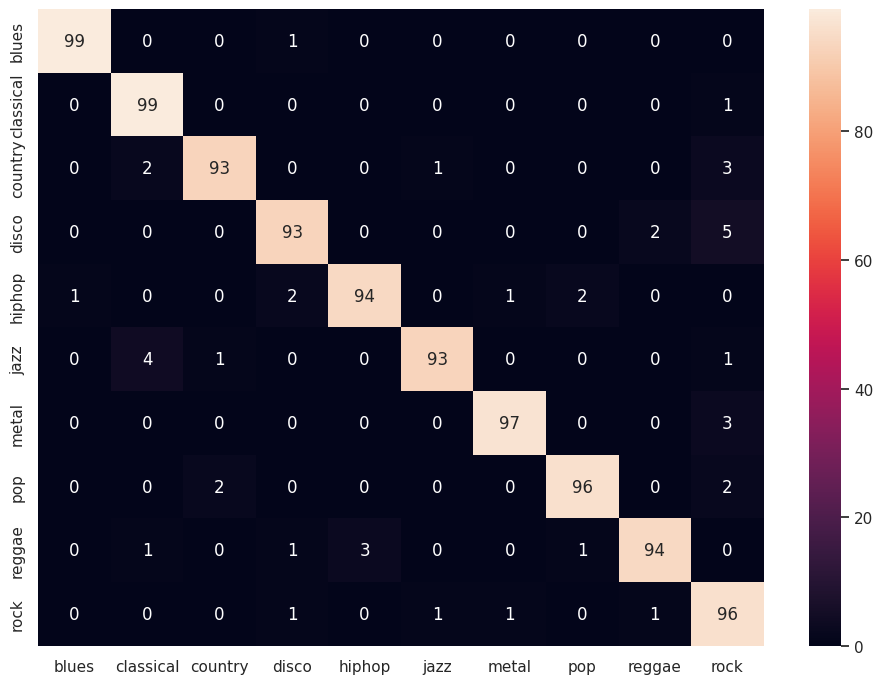

In [ ]:
cm = sns.heatmap(two_way_B2_d_cm_record[2], annot=True, xticklabels=labels, yticklabels=labels)

In [ ]:
mean = np.zeros((10,10))

for mat in two_way_B2_d_cm_record:
  mean += mat

mean = mean / len(two_way_B2_d_cm_record)
mean

array([[95.2,  0.2,  2.2,  0.3,  0. ,  0.9,  0.1,  0. ,  0.3,  0.8],
       [ 0.2, 98.2,  0.3,  0. ,  0. ,  0.6,  0. ,  0.1,  0.1,  0.5],
       [ 0.3,  0.9, 92.9,  0.9,  0. ,  1.5,  0.1,  0.7,  0.4,  1.9],
       [ 0. ,  0.7,  0.8, 94.9,  0.5,  0. ,  0.2,  0.8,  0.3,  1.8],
       [ 0.3,  0.2,  0.2,  1.1, 92.8,  0. ,  0.8,  2.3,  1.3,  0.7],
       [ 0.6,  3.4,  1. ,  0.2,  0. , 92.3,  0. ,  0.4,  0.1,  1. ],
       [ 0.3,  0. ,  0.3,  0.5,  0.8,  0. , 96.6,  0. ,  0.1,  1.4],
       [ 0. ,  0.3,  0.7,  1.6,  0.5,  0.6,  0. , 94.4,  0.5,  1.4],
       [ 0. ,  0.4,  0.7,  0.5,  1.9,  0.2,  0.1,  0.8, 94.8,  0.6],
       [ 0.3,  0.5,  2. ,  1.4,  0.2,  0.7,  2.3,  0.8,  1.4, 90.1]])

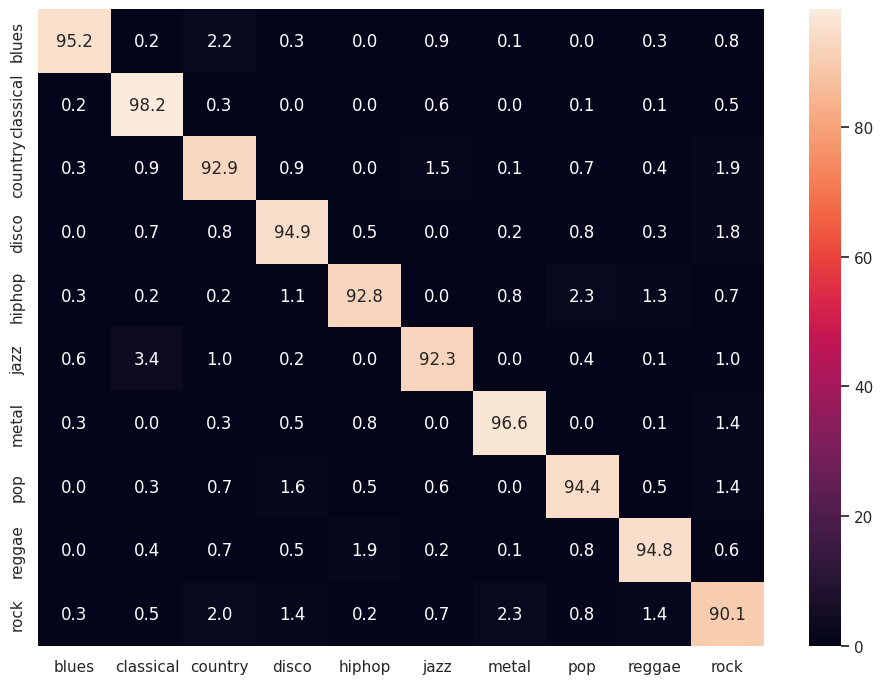

In [ ]:
cm_mean = sns.heatmap(mean, annot=True, fmt=".1f", xticklabels=labels, yticklabels=labels)

# Results Visualization

In [ ]:
results = pd.read_csv(DRIVE_PATH + '/results.csv')
results

,model,mode,sub_mode,avg_accuracy
0,audio_A1,audio,A1,0.948297
1,audio_A2,audio,A2,0.944389
2,audio_A3,audio,A3,0.942400
3,audio_A4,audio,A4,0.948898
4,audio_B1,audio,B1,0.949499
5,audio_B2,audio,B2,0.943988
6,audio_B3,audio,B3,0.942385
7,audio_B4,audio,B4,0.950601
8,vision_a,vision,a,0.948397
9,vision_b,vision,b,0.946293


In [ ]:
marker_column = [1024, 512, 256, 128, 1024, 512, 256, 128, -1, 128, 256, 512, 1024, 1024, 512, 256, 128, 1024, 512, 256, 128, 0]
results['dense_layer_marker'] = marker_column
results

,model,mode,sub_mode,avg_accuracy,dense_layer_marker
0,audio_A1,audio,A1,0.948297,1024
1,audio_A2,audio,A2,0.944389,512
2,audio_A3,audio,A3,0.942400,256
3,audio_A4,audio,A4,0.948898,128
4,audio_B1,audio,B1,0.949499,1024
5,audio_B2,audio,B2,0.943988,512
6,audio_B3,audio,B3,0.942385,256
7,audio_B4,audio,B4,0.950601,128
8,vision_a,vision,a,0.948397,-1
9,vision_b,vision,b,0.946293,128


In [ ]:
results_mod = results.drop(['model', 'mode', 'sub_mode'], axis = 1)
results_mod = results_mod.drop([8]).reset_index(drop = True)
results_mod

,avg_accuracy,dense_layer_marker
0,0.948297,1024
1,0.944389,512
2,0.942400,256
3,0.948898,128
4,0.949499,1024
5,0.943988,512
6,0.942385,256
7,0.950601,128
8,0.946293,128
9,0.951002,256


In [ ]:
model_col = ['one-way (audio A)', 'one-way (audio A)', 'one-way (audio A)', 'one-way (audio A)',
             'one-way (audio B)', 'one-way (audio B)', 'one-way (audio B)', 'one-way (audio B)',
             'one-way (vision)', 'one-way (vision)', 'one-way (vision)', 'one-way (vision)',
             'two-way (audio A)', 'two-way (audio A)', 'two-way (audio A)', 'two-way (audio A)',
             'two-way (audio B)', 'two-way (audio B)', 'two-way (audio B)', 'two-way (audio B)',
             'original model (baseline)']
results_mod['model'] = model_col
results_mod

,avg_accuracy,dense_layer_marker,model
0,0.948297,1024,one-way (audio A)
1,0.944389,512,one-way (audio A)
2,0.942400,256,one-way (audio A)
3,0.948898,128,one-way (audio A)
4,0.949499,1024,one-way (audio B)
5,0.943988,512,one-way (audio B)
6,0.942385,256,one-way (audio B)
7,0.950601,128,one-way (audio B)
8,0.946293,128,one-way (vision)
9,0.951002,256,one-way (vision)


In [ ]:
def swap_rows(df, row1, row2):
    df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
    return df

In [ ]:
results_mod = swap_rows(results_mod, 8, 11)
results_mod = swap_rows(results_mod, 9, 10)
results_mod

,avg_accuracy,dense_layer_marker,model
0,0.948297,1024,one-way (audio A)
1,0.944389,512,one-way (audio A)
2,0.942400,256,one-way (audio A)
3,0.948898,128,one-way (audio A)
4,0.949499,1024,one-way (audio B)
5,0.943988,512,one-way (audio B)
6,0.942385,256,one-way (audio B)
7,0.950601,128,one-way (audio B)
8,0.943988,1024,one-way (vision)
9,0.942585,512,one-way (vision)


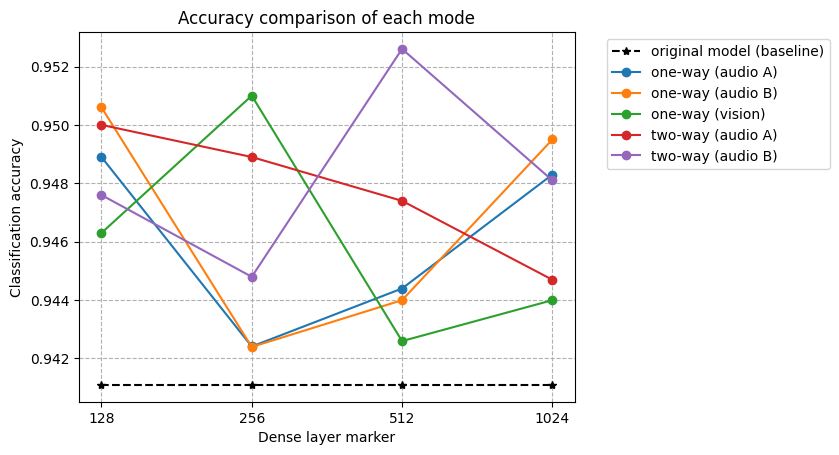

In [ ]:
plt.title('Accuracy comparison of each mode')
plt.xlabel('Dense layer marker')
plt.ylabel('Classification accuracy')

markers = ['128', '256', '512', '1024']

baseline = np.array([results_mod['avg_accuracy'][20]] * 4)
baseline_label = results_mod['model'][20]

plt.plot(markers, baseline, 'k*--', label = baseline_label)

for i in range(5):
  model_accuracies = results_mod['avg_accuracy'][i*4:(i+1)*4].to_numpy()[::-1]
  label = results_mod['model'][i*4]
  plt.plot(markers, model_accuracies, 'o-', label = label)

plt.grid(linestyle = '--')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('model_comparison.png', bbox_inches='tight')
plt.show()